# Alzheimer MRI Preprocessed Dataset
Preprocessed Alzheimer Disease MRI (Magnetic Resonance Imaging)

---

* #### 데이터셋 : [Kaggle](https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset?datasetId=2029496&sortBy=voteCount)
    
* #### 참고 : 
    * [의료이미지데이터 로드](https://www.kaggle.com/code/tomdomers/oasis-brain-analysis), 
    * [이미지 전처리](https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16)  
  
* #### 데이터 설명 :
    * 출처 : 여러 웹사이트/병원/공공데이터에서 수집되었습니다.
    * 포맷 : 데이터셋은 전처리된 MRI이미지로, 모두 128 x 128 픽셀로 조정되었습니다.
    * 구성 : 데어터셋은 총 4개의 클래스로 나누어져 있습니다.  
        * 비치매 (3200개 이미지)  
        * 매우 경증 치매 (2240개 이미지)    
        * 경도 치매 (896개 이미지)  
        * 중등도 치매 (64개 이미지)
---

## Presetting

### 1. Libraries

In [85]:
# !pip install koreanize_matplotlib
# !pip install nibabel
# !pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 3.3 MB 11.9 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  NOTE: The current PATH contains path(s) starting with `~`, which may not be expanded by all applications.
Defaulting to user installation because normal site-packages is not writeable


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import koreanize_matplotlib
import seaborn as sns

%matplotlib inline

In [2]:
# 파일 경로 관련
from glob import glob
import os

In [211]:
# 이미지 처리 관련
from PIL import Image
import nibabel as nib
import cv2
from skimage import transform
from scipy.ndimage import rotate


In [117]:
# 딥러닝 모델 관련
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory

### 2. Dataset Load

In [5]:
# 파일 경로 확인 > '분류명/파일명' 형태로 되어있음.
glob('../Preprocessed Alzheimer MRI/*')

['../Preprocessed Alzheimer MRI/Very_Mild_Demented',
 '../Preprocessed Alzheimer MRI/Moderate_Demented',
 '../Preprocessed Alzheimer MRI/Mild_Demented',
 '../Preprocessed Alzheimer MRI/Non_Demented']

In [6]:
# root_dir 설정 > 하위목록 확인
root_dir = '../Preprocessed Alzheimer MRI/'
os.listdir(root_dir)

['Very_Mild_Demented',
 'Moderate_Demented',
 'Mild_Demented',
 'Non_Demented',
 '.ipynb_checkpoints']

In [7]:
# root_dir 경로 안에 있는 폴더마다 img가져오고, 폴더명을 y값으로 저장
img_list = []
folder_list = []
for folder_name in os.listdir(root_dir):
    for img in os.listdir(root_dir + folder_name):
        img_list.append(Image.open(f'{root_dir + folder_name}/{img}'))  # img 가져오기
        folder_list.append(folder_name)  # folder_name을 y값으로 저장

In [8]:
print(pd.Series(folder_list).value_counts())
print('Total : ', pd.Series(folder_list).value_counts().sum())

Non_Demented          3200
Very_Mild_Demented    2240
Mild_Demented          896
Moderate_Demented       64
dtype: int64
Total :  6400


In [9]:
# group명 변경하기
# 기존 : 4개 그룹 => 변경 : 3개 그룹(non, mild, moderate)
group_list = []
for folder in folder_list :
    if folder == 'Non_Demented': 
        group_list.append('non')
    elif folder == 'Very_Mild_Demented': 
        group_list.append('mild')
    elif (folder == 'Mild_Demented' or folder == 'Moderate_Demented'): 
        group_list.append('moderate')

group_counts = pd.Series(group_list).value_counts()
print(group_counts)
print('Total : ', group_counts.sum())

non         3200
mild        2240
moderate     960
dtype: int64
Total :  6400


### 3. Dataset 확인

총 4개의 그룹으로 나누어져 있음. (Moderate_Demented 중증 치매 환자의 데이터는 전체 1% 밖에 되지 않음.)  
뇌는 복잡한 구조여서 평균적인 이미지를 만들어서는 그룹간의 차이를 구별하기 어려움.

non         3200
mild        2240
moderate     960
dtype: int64


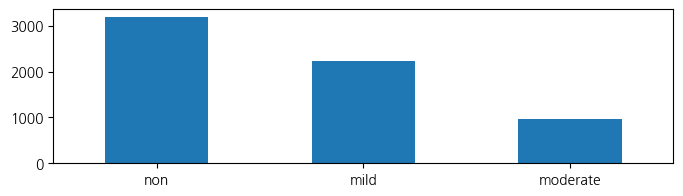

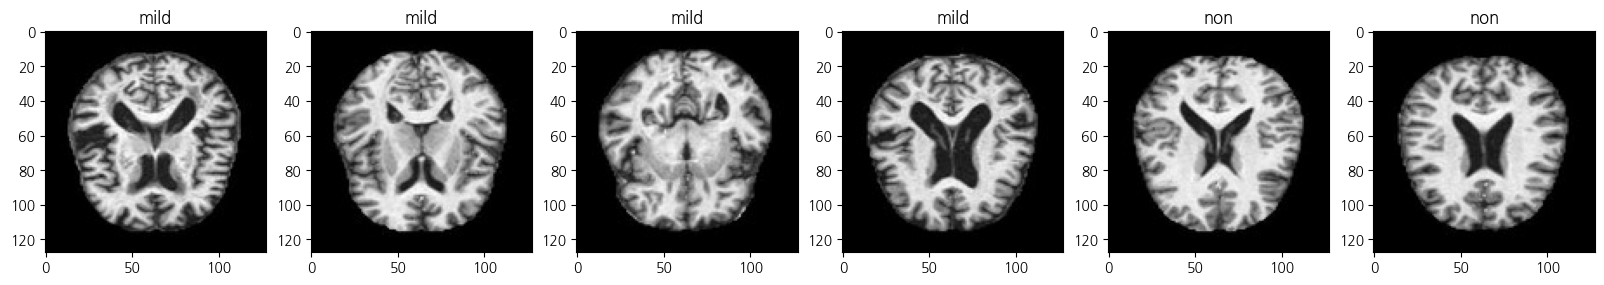

In [288]:
# group_list에 그룹별로 잘 나뉘었는지 확인
print(pd.Series(group_list).value_counts())
plt.figure(figsize=(8, 2))
pd.Series(group_list).value_counts().plot(kind='bar', rot=0);

# img_list에 담긴 이미지 파일 확인
fig, axes = plt.subplots(1, 6, figsize=(20, 5))
for i in range(len(axes)):
    num = np.random.randint(0, group_counts.sum())
    axes[i].imshow(img_list[num], cmap='gray')
    axes[i].set_title(group_list[num])

그룹별 평균적인 뇌 이미지


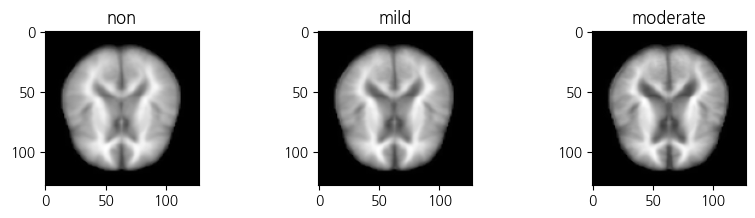

In [286]:
fig, axes = plt.subplots(1, group_counts.nunique(), figsize=(10, 2))
print('그룹별 평균적인 뇌 이미지')
for i in range(group_counts.nunique()):
    group_name = pd.Series(group_list).value_counts().index[i]
    img_arrays = [np.array(img_group[0]) for img_group in list(zip(img_list, group_list))
             if img_group[1] == group_name]
    img_arrays = np.array(img_arrays) / 255
    mean_img = np.mean(np.stack(img_arrays), axis=0)
    axes[i].imshow(mean_img, cmap='gray')
    axes[i].set_title(group_name)

## Deep-Learning 모델

### 4. Preprocessing

In [12]:
# X값으로 사용할 데이터 (위의 img를 np.array형태로 변환해서 저장) 
X = [np.array(img) for img in img_list]

# 이미지 array의 값을 0~1로 정규화
X = np.array(X)/255
X.shape

(6400, 128, 128)

In [13]:
# group_list의 group이름을 숫자로 인코딩 > y에 담아주기 (정답값)
y = []
for group_name in group_list :
    if group_name=='non': y.append(0)
    elif group_name=='mild': y.append(1)
    elif group_name=='moderate' : y.append(2)
    
y = to_categorical(y)
y.shape

(6400, 3)

In [14]:
# 모델에 넣을 수 있는 형태로 변환
# Input 0 of layer "conv2d" is incompatible with the layer: 
# expected min_ndim=4, found ndim=3. Full shape received: (None, 128, 128)
X = X.reshape(6400, 128, 128, 1)

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4800, 128, 128, 1), (1600, 128, 128, 1), (4800, 3), (1600, 3))

### 5. Model 만들기

In [15]:
# CNN 모델 생성
cnn=Sequential()

#initially 64 convolution nodes
cnn.add(Conv2D(64,(3,3),padding="same",activation='relu',input_shape=X_train.shape[1:]))
#add a Max Pooling layer
cnn.add(MaxPooling2D())

#another 32 convolution nodes
cnn.add(Conv2D(32,(3,3),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())

#Add 32 convolutions
cnn.add(Conv2D(32,(2,2),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())

#Flatten before adding fully connected layer
cnn.add(Flatten())

#Add a hidden layer with 100 nodes
cnn.add(Dense(100,activation='relu'))

#Add another hidden layer with 50 nodes
cnn.add(Dense(50,activation='relu'))

# Add final ouptput layer : 클래스의 개수대로 만들어줌 (다중분류 softmax)
cnn.add(Dense(group_counts.nunique(), activation='softmax'))

2023-05-04 05:53:28.402713: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 05:53:29.064569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1553] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14888 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:e0:00.0, compute capability: 7.0


In [16]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0

### 6. Model 학습

In [17]:
# compile
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# 모델 훈련
history = cnn.fit(X_train, y_train, 
                  validation_split=0.2,
                  shuffle=True,
#                   class_weight=,
                  epochs=20,
                 )

Epoch 1/20


2023-05-04 05:53:31.357761: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


120/120 [==============================] - 4s 11ms/step - loss: 0.9681 - accuracy: 0.5068 - val_loss: 0.8812 - val_accuracy: 0.5469
Epoch 2/20
120/120 [==============================] - 1s 8ms/step - loss: 0.8672 - accuracy: 0.5711 - val_loss: 0.8246 - val_accuracy: 0.6198
Epoch 3/20
120/120 [==============================] - 1s 8ms/step - loss: 0.7675 - accuracy: 0.6393 - val_loss: 0.7083 - val_accuracy: 0.6823
Epoch 4/20
120/120 [==============================] - 1s 8ms/step - loss: 0.6413 - accuracy: 0.7096 - val_loss: 0.5946 - val_accuracy: 0.7490
Epoch 5/20
120/120 [==============================] - 1s 8ms/step - loss: 0.4466 - accuracy: 0.8174 - val_loss: 0.5219 - val_accuracy: 0.7854
Epoch 6/20
120/120 [==============================] - 1s 8ms/step - loss: 0.3180 - accuracy: 0.8740 - val_loss: 0.4206 - val_accuracy: 0.8240
Epoch 7/20
120/120 [==============================] - 1s 8ms/step - loss: 0.1827 - accuracy: 0.9336 - val_loss: 0.2942 - val_accuracy: 0.8927
Epoch 8/20
120/1

### 7. Model 평가

In [20]:
def result_summary(model, X_test, y_test):
    """
    model, X_test, y_test를 입력하면 confusion matrix, classification report를 보여주고
    y_pred_val을 리턴하는 함수
    """
    # X_test에 대한 정답값 예측
    y_pred = model.predict(X_test, verbose=0);
    
    # argmax로 클래스 중 정답값 선택
    y_test_val = [np.argmax(y) for y in y_test]
    y_pred_val = [np.argmax(y) for y in y_pred]

    # Classification Report
    clr = classification_report(y_test_val, y_pred_val)
    print("Classification Report\n----------------------\n", clr)

    # Confusion Matrix
    cm = confusion_matrix(y_test_val, y_pred_val)
    print("\n\nConfusion Matrix\n----------------------")
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual");

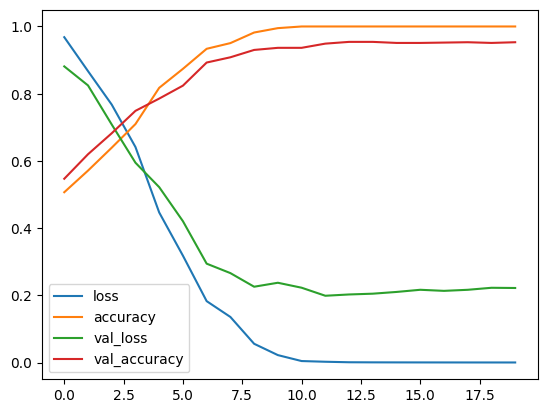

In [19]:
pd.DataFrame(history.history).plot();

Classification Report
----------------------
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       773
           1       0.96      0.95      0.96       586
           2       0.96      0.91      0.94       241

    accuracy                           0.96      1600
   macro avg       0.96      0.95      0.95      1600
weighted avg       0.96      0.96      0.96      1600



Confusion Matrix
----------------------


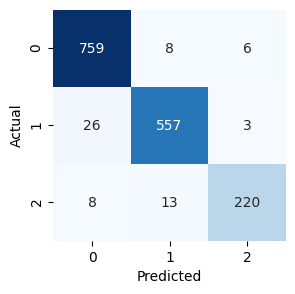

In [21]:
result_summary(cnn, X_test, y_test)

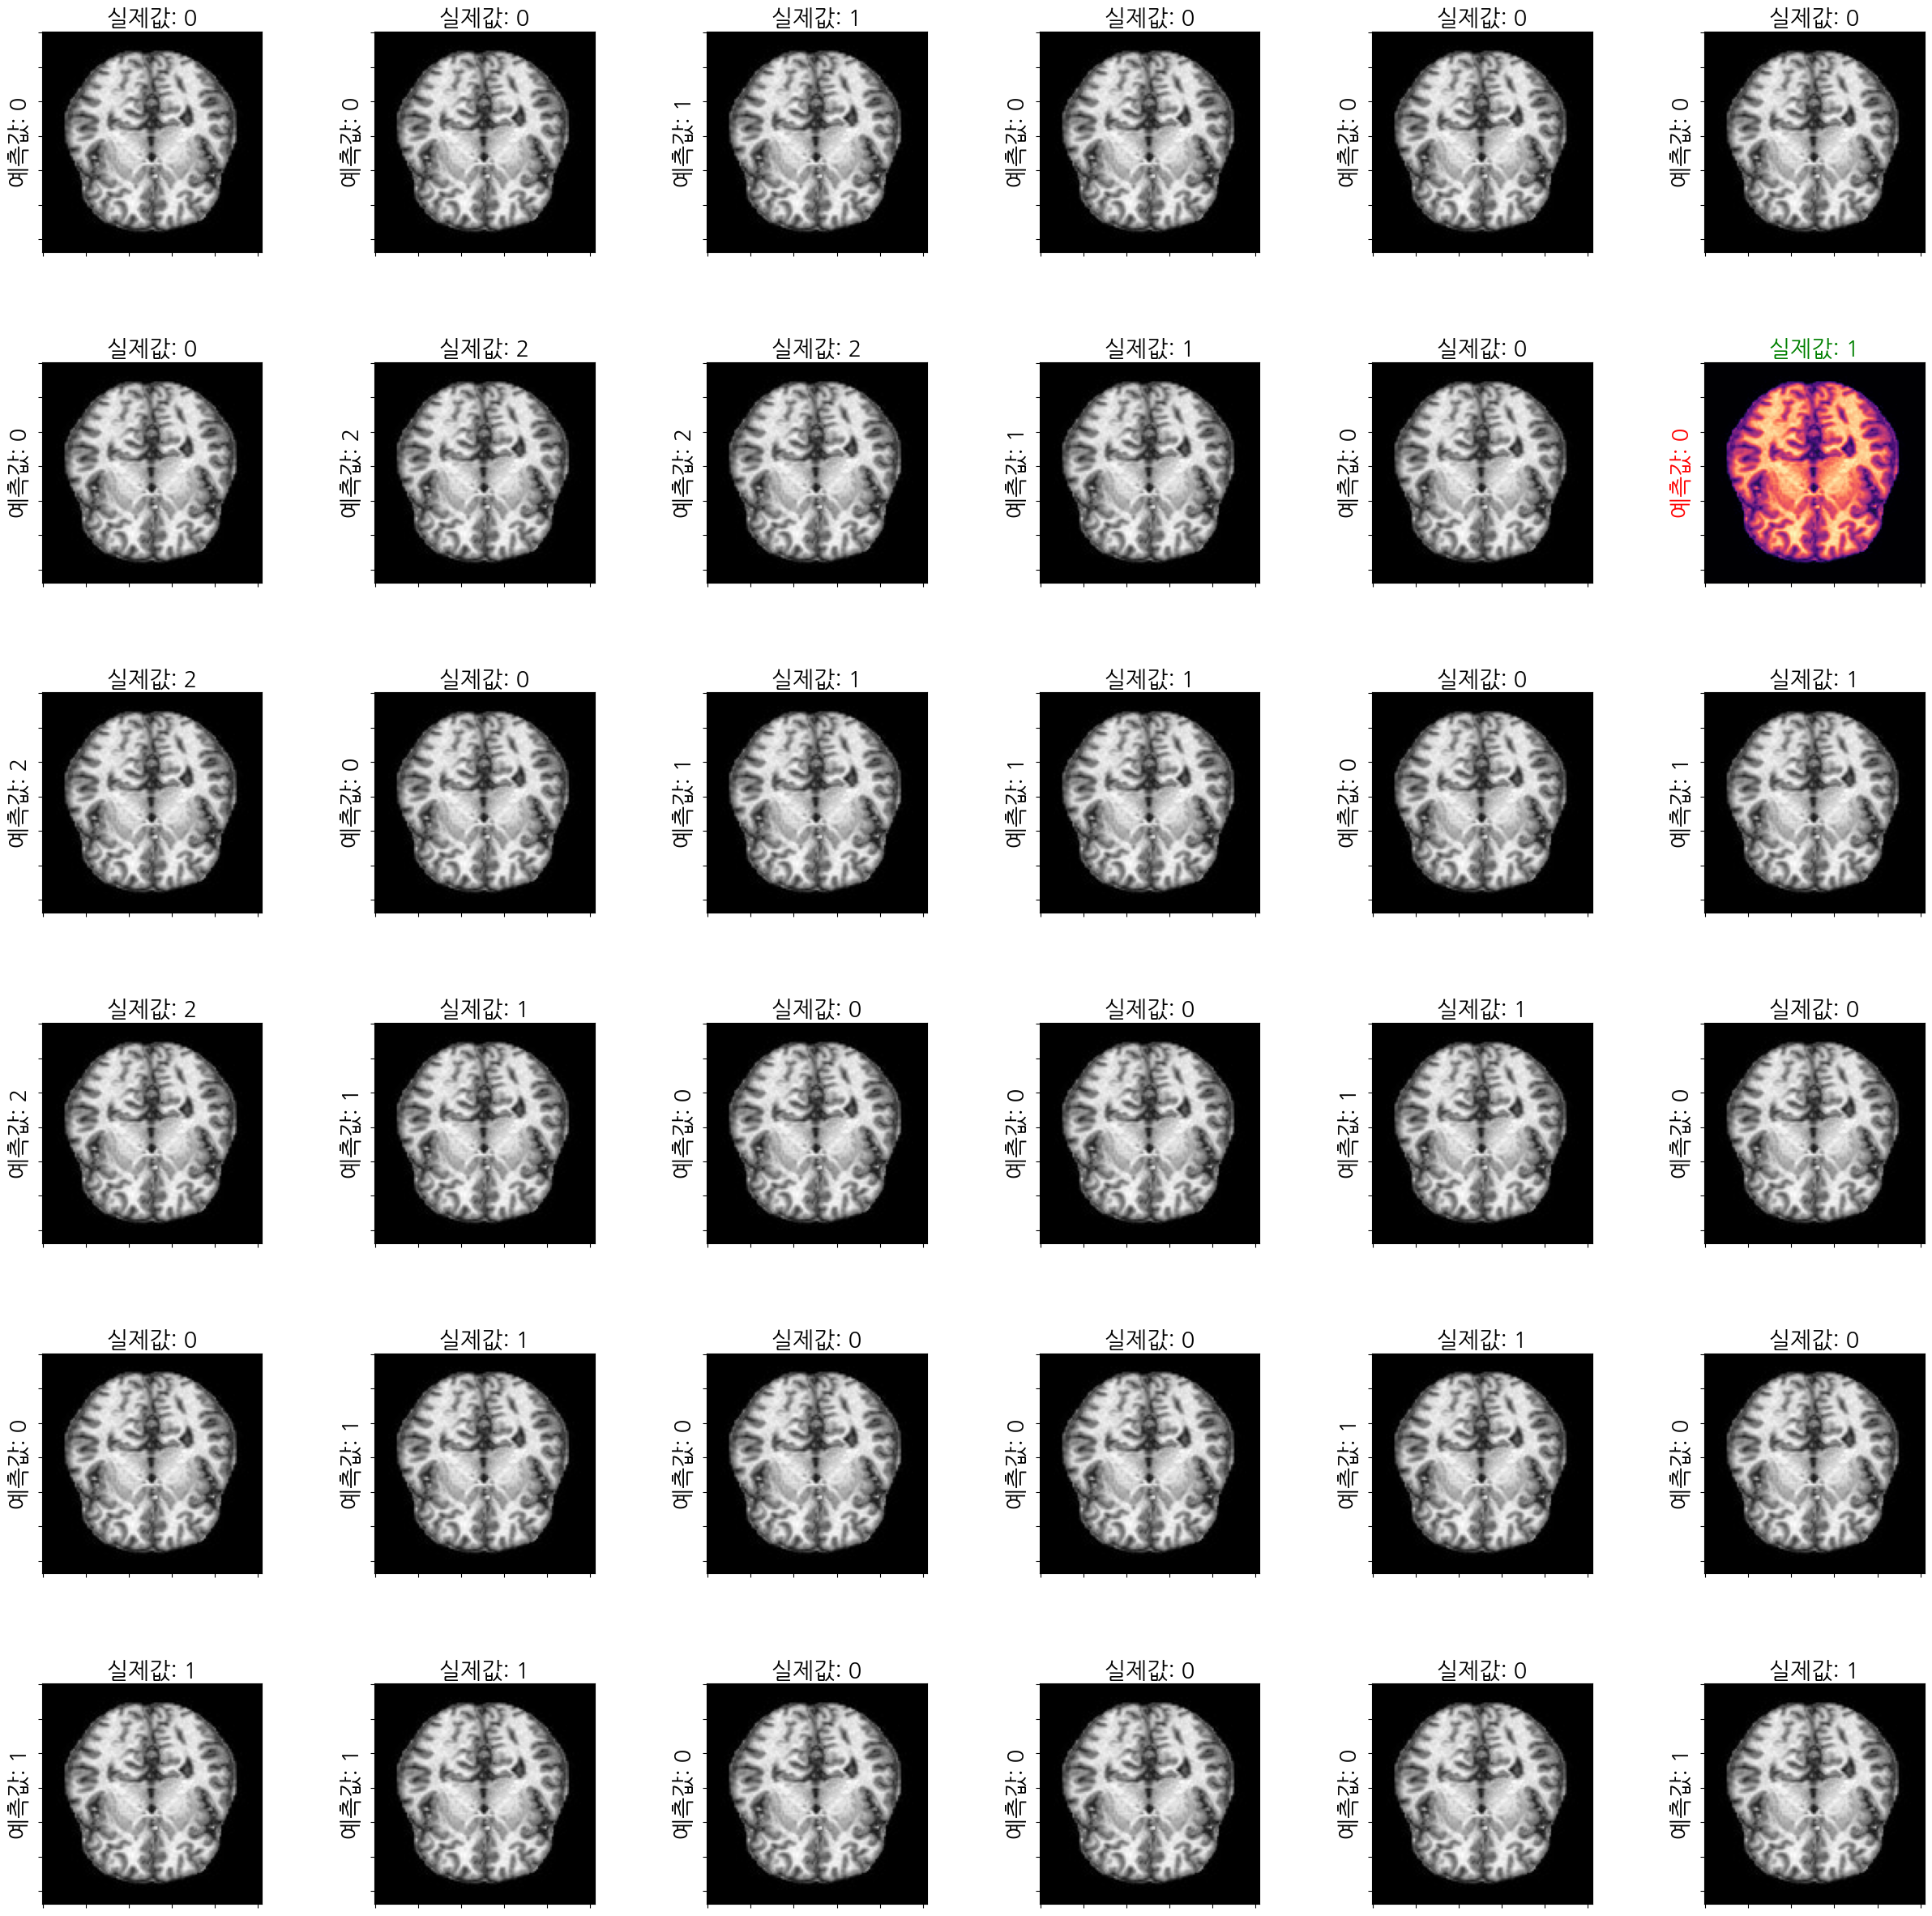

In [74]:
# 예측결과 예시
fig, axes = plt.subplots(6, 6, figsize=(30, 30))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
w = (axes.shape)[0]
h = (axes.shape)[1]

for i in range(0, w*h):
    # 랜덤숫자 만들기
    rand = np.random.randint(0, len(X_test))
    
    # X_test, y_test에서 rand번째 값 가져오기
    y_pred = cnn.predict(X_test[rand].reshape(1, 128, 128, 1), verbose=0)
    y_pred_val = np.argmax(y_pred)
    y_test_val = np.argmax(y_test[rand])
    
    # actual, predicted, img 
    axes[i//w, i%w].set_title(f'실제값: {y_test_val}', fontsize=20, 
                              color='green' if y_test_val!=y_pred_val else 'black')
    axes[i//w, i%w].set_ylabel(f'예측값: {y_pred_val}', fontsize=20, 
                              color='red' if y_test_val!=y_pred_val else 'black')
    axes[i//w, i%w].imshow(X_test[num], 
                              cmap='gray' if y_test_val==y_pred_val else 'magma')
    axes[i//w, i%w].set_xticklabels([])
    axes[i//w, i%w].set_yticklabels([])

# OASIS-2

In [81]:
dir_path = sorted(glob('../OASIS-2 dataset/*'))

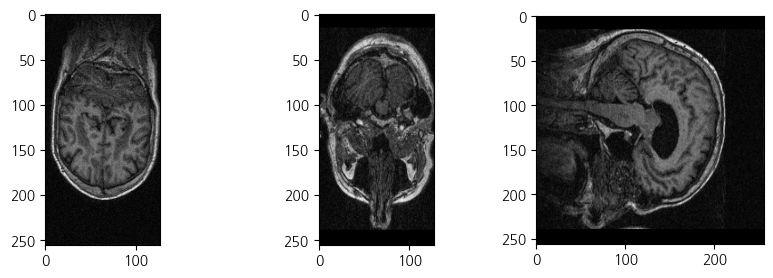

In [289]:
# 이미지 파일 경로
filepath = '../OASIS-2 dataset/OAS2_0017_MR3/mpr-4.nifti.img'

# 이미지 파일 불러오기
img = nib.load(filepath)

# 데이터 얻기
data = img.get_fdata()

# 이미지 시각화
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].imshow(data[70, :, :], cmap='gray')
axes[1].imshow(data[:, 70, :], cmap='gray')
axes[2].imshow(data[:, :, 70], cmap='gray');


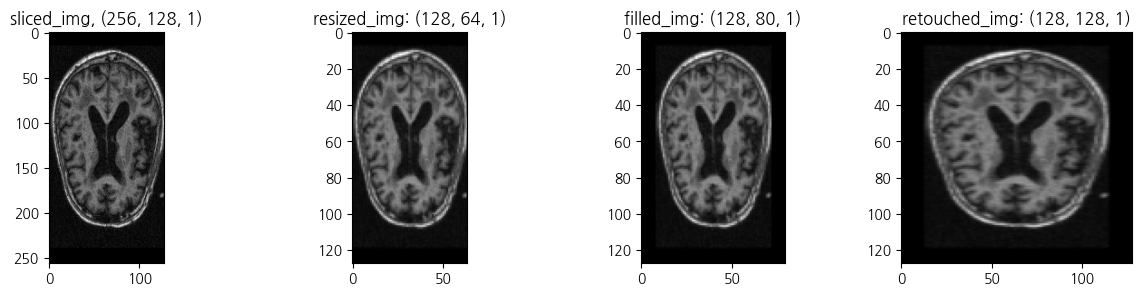

In [285]:
# nifti.img 파일 읽어오기
file = nib.load(filepath)
img_data = file.get_fdata()

# 이미지 처리 과정 (OASIS-2 데이터셋을 preprocessed처럼 만들기)
fig, axes = plt.subplots(1, 4, figsize=(15, 3))

# slicing
sliced_img = img_data[:, 140, :]
axes[0].imshow(sliced_img, cmap='gray')
axes[0].set_title(f'sliced_img, {sliced_img.shape}')

# resizing
resized_img = transform.resize(sliced_img, (128, 64, 1), anti_aliasing=True)
axes[1].imshow(resized_img, cmap='gray')
axes[1].set_title(f'resized_img: {resized_img.shape}')

# filling
h, w, _ = resized_img.shape
filled_img = np.zeros((128, 80, 1))
y = (filled_img.shape[0] - h) // 2
x = (filled_img.shape[1] - w) // 2
filled_img[y:y+h, x:x+w, :] = resized_img
axes[2].imshow(filled_img, cmap='gray')
axes[2].set_title(f'filled_img: {filled_img.shape}')

# resizing
retouched_img = transform.resize(filled_img, (128, 128, 1), anti_aliasing=True)
axes[3].imshow(retouched_img, cmap='gray')
axes[3].set_title(f'retouched_img: {retouched_img.shape}')

plt.show()

### 두개골 지우기

In [116]:
# 이미지 파일 경로
filepath = '../OASIS-2 dataset/OAS2_0017_MR3/mpr-4.nifti.img'

# 이미지 파일 불러오기
img = nib.load(filepath)

# 이미지 크기 조정
img = cv2.resize(
            img,
#             dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )

# 이미지를 그레이스케일로 변환
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 가우시안 블러를 이용하여 노이즈 제거
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# 이미지 이진화를 통해 배경과 뇌조직을 구분
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

# 작은 노이즈를 제거하기 위해 침식과 팽창 연산 적용
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# 경계선 찾기
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# 가장 큰 경계선을 찾아서 contour 변수에 저장
c = max(cnts, key=cv2.contourArea)

# 경계선의 가장자리 좌표 찾기
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# 이미지에 경계선 그리기
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# 경계선의 가장자리에 점 표시
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# 뇌 영역만 crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - resize() missing required argument 'dsize' (pos 2)
>  - resize() missing required argument 'dsize' (pos 2)
